In [263]:
from sklearn.linear_model import LinearRegression

from flood_tool.tool import Tool
from flood_tool.models import median_price_predictor
from flood_tool.data_processor import DataProcessor
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
tool = Tool()

In [265]:
import pandas as pd

df = pd.read_csv(tool.labelled_unit_data)

In [266]:
data_processor = DataProcessor(resource_path='../flood_tool/resources/', postcodes_path='../flood_tool/resources/postcodes_labelled.csv')

In [267]:
df = data_processor.human_data()

In [283]:
df

,postcode,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded,latitude,longitude,nearest_latitude,...,minOnRecord,typicalRangeHigh,typicalRangeLow,postcodeDistrict,catsPerHousehold,dogsPerHousehold,postcodeSector,households,numberOfPostcodeUnits,headcount
56,WV13 2LR,Unsurveyed/Urban,130.0,Walsall,1.0,84200.0,False,52.580546,-2.051506,52.558696,...,0.144,2.16,0.203,WV13,0.152259,0.174614,WV13 2,2987.0,221.0,7031.0
57,WV13 2EH,Unsurveyed/Urban,130.0,Walsall,1.0,184100.0,False,52.584989,-2.046582,52.558696,...,0.144,2.16,0.203,WV13,0.152259,0.174614,WV13 2,2987.0,221.0,7031.0
58,WV13 2HP,Unsurveyed/Urban,130.0,Walsall,1.0,171000.0,False,52.584190,-2.045297,52.558696,...,0.144,2.16,0.203,WV13,0.152259,0.174614,WV13 2,2987.0,221.0,7031.0
59,WV13 2HW,Unsurveyed/Urban,130.0,Walsall,1.0,128100.0,False,52.584082,-2.044278,52.558696,...,0.144,2.16,0.203,WV13,0.152259,0.174614,WV13 2,2987.0,221.0,7031.0
60,WV13 2LW,Unsurveyed/Urban,130.0,Walsall,1.0,171100.0,False,52.580467,-2.048318,52.558696,...,0.144,2.16,0.203,WV13,0.152259,0.174614,WV13 2,2987.0,221.0,7031.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29914,WV10 7EE,Stagnosols,120.0,South Staffordshire,1.0,301300.0,False,52.644651,-2.107536,52.671341,...,0.113,0.91,0.186,WV10,0.164938,0.189154,WV10 7,2651.0,250.0,9375.0
29915,WV10 7WE,Stagnosols,130.0,South Staffordshire,1.0,250200.0,False,52.645418,-2.092596,52.671341,...,0.113,0.91,0.186,WV10,0.164938,0.189154,WV10 7,2651.0,250.0,9375.0
29916,WV10 7BN,Cambisols,100.0,South Staffordshire,1.0,286200.0,False,52.669410,-2.132293,52.662979,...,0.166,1.33,0.229,WV10,0.164938,0.189154,WV10 7,2651.0,250.0,9375.0
29917,WV10 7AW,Stagnosols,120.0,South Staffordshire,1.0,221600.0,False,52.642925,-2.096832,52.671341,...,0.113,0.91,0.186,WV10,0.164938,0.189154,WV10 7,2651.0,250.0,9375.0


In [268]:
# tool.predict_median_house_price(df.postcode, method='linear_regression')

<Axes: >

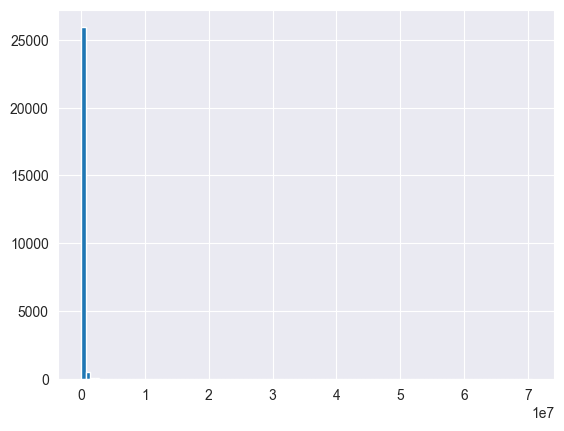

In [269]:
df.medianPrice.hist(bins=100)

<Axes: >

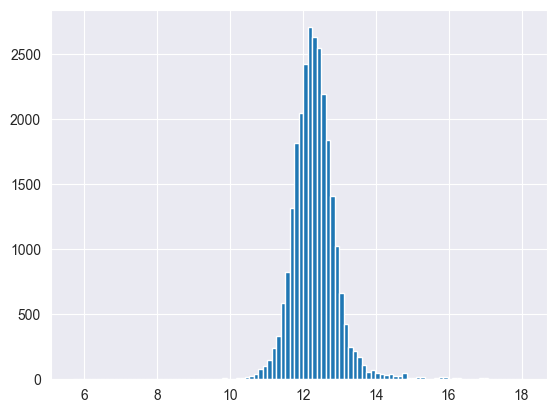

In [270]:
import numpy as np

np.log(df.medianPrice).hist(bins=100)

In [271]:
df.dropna(inplace=True)

In [272]:
from utils.utils import binning
from flood_tool.models.constant import RDS
from sklearn.model_selection import train_test_split
y = np.log(df.medianPrice) 
X = df.drop(columns=['medianPrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RDS, stratify=binning(y))

In [273]:
X_train.columns

Index(['postcode', 'soilType', 'elevation', 'localAuthority', 'riskLabel',
       'historicallyFlooded', 'latitude', 'longitude', 'nearest_latitude',
       'nearest_longitude', 'stationReference', 'stationName', 'latitude',
       'longitude', 'maxOnRecord', 'minOnRecord', 'typicalRangeHigh',
       'typicalRangeLow', 'postcodeDistrict', 'catsPerHousehold',
       'dogsPerHousehold', 'postcodeSector', 'households',
       'numberOfPostcodeUnits', 'headcount'],
      dtype='object')

In [274]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# num_cols = ['elevation', 'nearest_latitude', 'nearest_longitude', 'dogsPerHousehold']
num_cols = ['elevation']
# num_cols = ['nearest_latitude', 'nearest_longitude']
cat_cols = ['soilType']

num_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
    ]
)


In [275]:


from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

model_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model),
    ]
)

In [276]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['elevation']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['soilType'])])),
  ('model', KNeighborsRegressor(n_jobs=-1))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num',
  

In [277]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['soilType'])])),
                ('model', KNeighborsRegressor(n_jobs=-1))])

In [278]:
y_preds = model_pipe.predict(X_test)

In [279]:
# exponentiate
y_test = np.exp(y_test)
y_preds = np.exp(y_preds)

In [280]:
from utils.utils import compute_metrics
scores = compute_metrics(y_test, y_preds, regression=True)

2023-11-22 19:05:00,894 [utils.utils] INFO: mae: 87669.84910395215
2023-11-22 19:05:00,894 [utils.utils] INFO: mse: 27198987249.18709
2023-11-22 19:05:00,897 [utils.utils] INFO: rmse: 164921.15464423323
2023-11-22 19:05:00,898 [utils.utils] INFO: r2: 0.07954277322385961


In [281]:
y_test.mean()

251796.95652173914

In [282]:
y_preds.mean()

240220.4098135283